In [ ]:
# LightRAG System with OCR for Formula Search

This notebook implements a lightweight Retrieval-Augmented Generation (RAG) system with:
- YOLO-based document layout detection
- Formula recognition using pix2tex
- Text OCR using PaddleOCR
- Context-aware formula search and indexing
- Graph-based formula representation and retrieval

In [11]:
# Import required libraries
import os
import sys
import json
import pickle
from pathlib import Path
from typing import Dict, List, Set, Tuple, Optional, Any
from dataclasses import dataclass, field
from collections import defaultdict
import numpy as np
import cv2
from PIL import Image
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Add paths if needed
sys.path.insert(0, './PDF-Extract-Kit')

print("Python version:", sys.version)
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

Python version: 3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0]
PyTorch version: 2.9.0+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3090


## 1. Document Element Detection with YOLO

First, we'll set up YOLO for document layout detection to identify different elements like text blocks, formulas, tables, etc.

In [12]:
from ultralytics import YOLO

@dataclass
class DocumentElement:
    """Represents a detected element in the document"""
    element_type: str  # 'text', 'formula', 'table', 'figure', etc.
    bbox: Tuple[int, int, int, int]  # x1, y1, x2, y2
    confidence: float
    content: Optional[str] = None  # Recognized content
    page_num: int = 0
    element_id: Optional[int] = None
    context_before: Optional[str] = None  # Text before this element
    context_after: Optional[str] = None   # Text after this element


class YOLODocLayoutDetector:
    """Document layout detection using YOLO"""
    
    def __init__(self, model_path: str = "yolo-doclaynet/yolov10m-doclaynet.pt"):
        """Initialize YOLO model for document layout detection"""
        print(f"Loading YOLO model from {model_path}...")
        self.model = YOLO(model_path)
        
        # DocLayNet class mapping (11 classes from DocLayNet dataset)
        self.class_names = {
            0: 'Caption',
            1: 'Footnote',
            2: 'Formula',  # formulas
            3: 'List-item',
            4: 'Page-footer',
            5: 'Page-header',
            6: 'Picture',
            7: 'Section-header',
            8: 'Table',
            9: 'Text',
            10: 'Title'
        }
        print("YOLO model loaded successfully!")
    
    def detect_elements(self, image: np.ndarray, conf_threshold: float = 0.3) -> List[DocumentElement]:
        """
        Detect document elements in an image
        
        Args:
            image: Input image as numpy array (BGR format)
            conf_threshold: Confidence threshold for detections
            
        Returns:
            List of DocumentElement objects
        """
        # Run inference
        results = self.model(image, conf=conf_threshold, verbose=False)
        
        elements = []
        
        for result in results:
            boxes = result.boxes
            
            for i in range(len(boxes)):
                # Get box coordinates
                x1, y1, x2, y2 = boxes.xyxy[i].cpu().numpy().astype(int)
                confidence = float(boxes.conf[i].cpu().numpy())
                class_id = int(boxes.cls[i].cpu().numpy())
                
                # Get element type
                element_type = self.class_names.get(class_id, 'unknown')
                
                # Create DocumentElement
                element = DocumentElement(
                    element_type=element_type,
                    bbox=(x1, y1, x2, y2),
                    confidence=confidence,
                    element_id=len(elements)
                )
                
                elements.append(element)
        
        # Sort elements by position (top to bottom, left to right)
        elements = self._sort_elements_reading_order(elements)
        
        return elements
    
    def _sort_elements_reading_order(self, elements: List[DocumentElement]) -> List[DocumentElement]:
        """Sort elements in reading order (top to bottom, left to right)"""
        # Sort by y-coordinate first (top to bottom), then by x-coordinate (left to right)
        sorted_elements = sorted(elements, key=lambda e: (e.bbox[1], e.bbox[0]))
        
        # Reassign element IDs
        for i, elem in enumerate(sorted_elements):
            elem.element_id = i
        
        return sorted_elements
    
    def visualize_detections(self, image: np.ndarray, elements: List[DocumentElement], 
                            figsize=(15, 10)) -> plt.Figure:
        """Visualize detected elements on the image"""
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        # Convert BGR to RGB for display
        if len(image.shape) == 3 and image.shape[2] == 3:
            display_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            display_image = image
        
        ax.imshow(display_image)
        
        # Color map for different element types
        color_map = {
            'Caption': 'yellow',
            'Footnote': 'lightgray',
            'Formula': 'red',
            'List-item': 'pink',
            'Page-footer': 'gray',
            'Page-header': 'darkgray',
            'Picture': 'green',
            'Section-header': 'darkblue',
            'Table': 'orange',
            'Text': 'blue',
            'Title': 'purple'
        }
        
        for elem in elements:
            x1, y1, x2, y2 = elem.bbox
            color = color_map.get(elem.element_type, 'black')
            
            # Draw rectangle
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                     linewidth=2, edgecolor=color, 
                                     facecolor='none', alpha=0.7)
            ax.add_patch(rect)
            
            # Add label
            label = f"{elem.element_type} ({elem.confidence:.2f})"
            ax.text(x1, y1-5, label, color=color, fontsize=8, 
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
        
        ax.axis('off')
        ax.set_title("Document Layout Detection", fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        return fig


# Test YOLO detection
print("Testing YOLO Document Layout Detector...")
detector = YOLODocLayoutDetector()
print("Detector initialized!")


Testing YOLO Document Layout Detector...
Loading YOLO model from yolo-doclaynet/yolov10m-doclaynet.pt...
YOLO model loaded successfully!
Detector initialized!


## 2. Formula Recognition with pix2tex

Set up pix2tex for converting formula images to LaTeX.

In [13]:
from pix2tex.cli import LatexOCR

class FormulaRecognizer:
    """Formula recognition using pix2tex"""
    
    def __init__(self):
        """Initialize pix2tex model"""
        print("Loading pix2tex model...")
        self.model = LatexOCR()
        print("pix2tex model loaded!")
    
    def recognize_formula(self, image: np.ndarray) -> str:
        """
        Recognize formula from image
        
        Args:
            image: Formula image as numpy array
            
        Returns:
            LaTeX string
        """
        # Convert to PIL Image if needed
        if isinstance(image, np.ndarray):
            # Convert BGR to RGB if needed
            if len(image.shape) == 3 and image.shape[2] == 3:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            pil_image = Image.fromarray(image)
        else:
            pil_image = image
        
        # Recognize formula
        try:
            latex = self.model(pil_image)
            return latex
        except Exception as e:
            print(f"Error recognizing formula: {e}")
            return ""
    
    def batch_recognize(self, images: List[np.ndarray]) -> List[str]:
        """Recognize multiple formulas"""
        results = []
        for img in images:
            latex = self.recognize_formula(img)
            results.append(latex)
        return results


# Initialize formula recognizer
print("Initializing Formula Recognizer...")
formula_recognizer = FormulaRecognizer()
print("Formula recognizer ready!")

Initializing Formula Recognizer...
Loading pix2tex model...
pix2tex model loaded!
Formula recognizer ready!


## 3. Text Recognition with PaddleOCR

Set up PaddleOCR for text recognition in document regions.

In [45]:

class TextRecognizer:
    """Text recognition using PaddleOCR"""
    
    def __init__(self, lang='ru'):
        """Initialize PaddleOCR with optimized settings for Russian text"""
        print(f"Loading PaddleOCR ({lang})...")
        # Optimized settings for Russian text recognition
        self.ocr = PaddleOCR(
            use_textline_orientation=True,
            lang=lang,
            text_det_thresh=0.2,    # Even lower threshold
            text_det_box_thresh=0.3,
            text_recognition_batch_size=6,
        )
        print("PaddleOCR loaded!")
    
    def preprocess_image(self, image: np.ndarray) -> np.ndarray:
        """
        Preprocess image for better OCR results
        
        Args:
            image: Input image
            
        Returns:
            Preprocessed image
        """
        # Simple preprocessing: just ensure minimum size
        height = image.shape[0]
        width = image.shape[1]
        
        # Resize if too small (minimum height 32 pixels for PaddleOCR)
        if height < 32:
            scale = 48 / height  # Make it 48 pixels high for better quality
            new_width = int(width * scale)
            image = cv2.resize(image, (new_width, 48), interpolation=cv2.INTER_CUBIC)
        
        return image
    
    def recognize_text(self, image: np.ndarray, preprocess: bool = True) -> str:
        """
        Recognize text from image
        
        Args:
            image: Text region image as numpy array
            preprocess: Whether to apply preprocessing
            
        Returns:
            Recognized text string
        """
        try:
            # Apply minimal preprocessing if enabled
            if preprocess:
                processed_img = self.preprocess_image(image)
            else:
                processed_img = image
            
            # Run OCR
            result = self.ocr.predict(processed_img)
            
            if result is None or len(result) == 0:
                return ""
            
            # Extract text from result - handle different result formats
            text_lines = []
            
            # Result format: [[[box], (text, confidence)], ...]
            for item in result:
                if item is None:
                    continue
                    
                # Handle nested list structure
                if isinstance(item, list):
                    for line in item:
                        if line and isinstance(line, (list, tuple)) and len(line) >= 2:
                            # line[0] is bbox, line[1] is (text, confidence) tuple
                            if isinstance(line[1], (list, tuple)) and len(line[1]) >= 2:
                                text = line[1][0]  # text
                                conf = line[1][1]  # confidence
                                
                                # Lower confidence threshold for Russian text
                                if conf > 0.3:  # Reduced from 0.5
                                    text_lines.append(str(text))
            
            result_text = " ".join(text_lines)
            return result_text if result_text else ""
            
        except Exception as e:
            print(f"Error recognizing text: {e}")
            return ""
    
    def recognize_text_with_boxes(self, image: np.ndarray, preprocess: bool = True) -> List[Tuple[List[List[int]], str, float]]:
        """
        Recognize text with bounding boxes
        
        Returns:
            List of (bbox, text, confidence) tuples
        """
        try:
            # Apply minimal preprocessing if enabled
            if preprocess:
                processed_img = self.preprocess_image(image)
            else:
                processed_img = image
            
            result = self.ocr.predict(processed_img)
            
            if result is None or len(result) == 0:
                return []
            
            recognized = []
            
            # Handle nested list structure
            for item in result:
                if item is None:
                    continue
                    
                if isinstance(item, list):
                    for line in item:
                        if line and isinstance(line, (list, tuple)) and len(line) >= 2:
                            bbox = line[0]
                            if isinstance(line[1], (list, tuple)) and len(line[1]) >= 2:
                                text = str(line[1][0])
                                conf = float(line[1][1])
                                
                                # Lower confidence threshold
                                if conf > 0.3:
                                    recognized.append((bbox, text, conf))
            
            return recognized
        except Exception as e:
            print(f"Error recognizing text: {e}")
            return []


# Initialize text recognizer for Russian
print("Initializing Text Recognizer for Russian...")
text_recognizer = TextRecognizer(lang='ru')
print("Text recognizer ready!")


Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/alexey/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/alexey/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.


Initializing Text Recognizer for Russian...
Loading PaddleOCR (ru)...


Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/alexey/.paddlex/official_models/UVDoc`.
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/alexey/.paddlex/official_models/UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/alexey/.paddlex/official_models/PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/alexey/.paddlex/official_models/PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/alexey/.paddlex/official_models/PP-OCRv5_server_det`.
Creating model: ('PP-OCRv

PaddleOCR loaded!
Text recognizer ready!


## 4. Document Processor - Combining All OCR Components

Create a unified document processor that combines layout detection, formula recognition, and text OCR.

In [46]:

class DocumentProcessor:
    """Process documents with layout detection and OCR"""
    
    def __init__(self, layout_detector: YOLODocLayoutDetector,
                 formula_recognizer: FormulaRecognizer,
                 text_recognizer: TextRecognizer):
        self.layout_detector = layout_detector
        self.formula_recognizer = formula_recognizer
        self.text_recognizer = text_recognizer
    
    def process_pdf(self, pdf_path: str, dpi: int = 200) -> List[DocumentElement]:
        """
        Process a PDF file and extract all elements with OCR
        
        Args:
            pdf_path: Path to PDF file
            dpi: DPI for rendering PDF pages
            
        Returns:
            List of DocumentElement objects with recognized content
        """
        print(f"Processing PDF: {pdf_path}")
        
        # Open PDF
        doc = fitz.open(pdf_path)
        all_elements = []
        
        for page_num in range(len(doc)):
            print(f"\nProcessing page {page_num + 1}/{len(doc)}...")
            
            # Render page to image
            page = doc[page_num]
            mat = fitz.Matrix(dpi/72, dpi/72)
            pix = page.get_pixmap(matrix=mat)
            
            # Convert to numpy array
            img = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.height, pix.width, pix.n)
            
            # Convert RGBA to BGR if needed
            if img.shape[2] == 4:
                img = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)
            elif img.shape[2] == 3:
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            
            # Detect layout elements
            elements = self.layout_detector.detect_elements(img)
            
            # Process each element with OCR
            for elem in elements:
                elem.page_num = page_num
                x1, y1, x2, y2 = elem.bbox
                
                # Extract element region
                elem_img = img[y1:y2, x1:x2]
                
                if elem_img.size == 0:
                    continue
                
                # Recognize content based on element type
                if elem.element_type == 'Formula':
                    # Formula recognition
                    print(f"  Recognizing formula at ({x1}, {y1})...")
                    latex = self.formula_recognizer.recognize_formula(elem_img)
                    elem.content = latex
                    print(f"    Formula: {latex[:100]}...")
                
                elif elem.element_type in ['Text', 'Title', 'Caption', 
                                          'List-item', 'Section-header', 'Footnote']:
                    # Text recognition
                    print(f"  Recognizing {elem.element_type} at ({x1}, {y1})...")
                    text = self.text_recognizer.recognize_text(elem_img)
                    elem.content = text
                    print(f"    Text: {text[:100]}...")
                
                else:
                    # Skip recognition for pictures, tables, headers, footers
                    elem.content = f"[{elem.element_type}]"
            
            # Add context to formulas
            elements = self._add_context_to_formulas(elements)
            
            all_elements.extend(elements)
        
        doc.close()
        
        print(f"\nProcessing complete! Total elements: {len(all_elements)}")
        return all_elements
    
    def _add_context_to_formulas(self, elements: List[DocumentElement]) -> List[DocumentElement]:
        """Add surrounding text context to formula elements"""
        for i, elem in enumerate(elements):
            if elem.element_type == 'Formula':
                # Find context before
                context_before = []
                for j in range(i-1, max(-1, i-3), -1):
                    if elements[j].element_type in ['Text', 'Title', 'Caption', 'Section-header']:
                        context_before.insert(0, elements[j].content or "")
                elem.context_before = " ".join(context_before)
                
                # Find context after
                context_after = []
                for j in range(i+1, min(len(elements), i+3)):
                    if elements[j].element_type in ['Text', 'Title', 'Caption', 'Section-header']:
                        context_after.append(elements[j].content or "")
                elem.context_after = " ".join(context_after)
        
        return elements
    
    def process_image(self, image_path: str) -> List[DocumentElement]:
        """Process a single image file"""
        print(f"Processing image: {image_path}")
        
        # Read image
        img = cv2.imread(image_path)
        
        # Detect layout
        elements = self.layout_detector.detect_elements(img)
        
        # Process each element
        for elem in elements:
            x1, y1, x2, y2 = elem.bbox
            elem_img = img[y1:y2, x1:x2]
            
            if elem_img.size == 0:
                continue
            
            if elem.element_type == 'Formula':
                latex = self.formula_recognizer.recognize_formula(elem_img)
                elem.content = latex
            elif elem.element_type in ['Text', 'Title', 'Caption', 'List-item', 'Section-header']:
                text = self.text_recognizer.recognize_text(elem_img)
                elem.content = text
            else:
                elem.content = f"[{elem.element_type}]"
        
        # Add context
        elements = self._add_context_to_formulas(elements)
        
        return elements


# Initialize document processor
print("Initializing Document Processor...")
doc_processor = DocumentProcessor(detector, formula_recognizer, text_recognizer)
print("Document processor ready!")


Initializing Document Processor...
Document processor ready!


## 5. Formula Graph Representation (from previous notebook)

Import the formula parsing and graph representation from the graph-based search system.

In [16]:
# Simplified formula parser and graph representation for RAG
import re
import hashlib
import networkx as nx

@dataclass
class FormulaNode:
    """Node in formula AST"""
    node_type: str
    value: str
    children: List['FormulaNode'] = field(default_factory=list)
    node_id: Optional[int] = None
    
    def __hash__(self):
        return hash((self.node_type, self.value))


class LaTeXParser:
    """Parse LaTeX formulas into AST"""
    
    def __init__(self):
        self.node_counter = 0
        self.operators = {'^': 3, '_': 3, '\\frac': 2, '\\sqrt': 2, '\\int': 2, 
                         '\\sum': 2, '*': 1, '/': 1, '+': 0, '-': 0, '=': -1}
    
    def tokenize(self, latex: str) -> List[str]:
        """Tokenize LaTeX formula"""
        latex = latex.strip()
        tokens = []
        i = 0
        
        while i < len(latex):
            if latex[i].isspace():
                i += 1
                continue
            
            if latex[i] == '\\':
                j = i + 1
                while j < len(latex) and latex[j].isalpha():
                    j += 1
                tokens.append(latex[i:j])
                i = j
            elif latex[i] in '{}':
                tokens.append(latex[i])
                i += 1
            elif latex[i] in '^_=+-*/()[]':
                tokens.append(latex[i])
                i += 1
            elif latex[i].isdigit() or latex[i] == '.':
                j = i
                while j < len(latex) and (latex[j].isdigit() or latex[j] == '.'):
                    j += 1
                tokens.append(latex[i:j])
                i = j
            else:
                tokens.append(latex[i])
                i += 1
        
        return tokens
    
    def parse(self, latex: str) -> FormulaNode:
        """Parse LaTeX to AST"""
        self.node_counter = 0
        tokens = self.tokenize(latex)
        if not tokens:
            return FormulaNode("empty", "", node_id=self._next_id())
        root = self._parse_expression(tokens, 0)[0]
        return root
    
    def _next_id(self) -> int:
        self.node_counter += 1
        return self.node_counter
    
    def _parse_expression(self, tokens: List[str], pos: int) -> Tuple[FormulaNode, int]:
        """Parse expression recursively"""
        if pos >= len(tokens):
            return FormulaNode("empty", "", node_id=self._next_id()), pos
        
        if tokens[pos] == '{':
            return self._parse_group(tokens, pos)
        
        if tokens[pos].startswith('\\'):
            return self._parse_command(tokens, pos)
        
        if tokens[pos] in ['^', '_']:
            return self._parse_script(tokens, pos)
        
        node = FormulaNode(self._classify_token(tokens[pos]), tokens[pos], node_id=self._next_id())
        return node, pos + 1
    
    def _parse_group(self, tokens: List[str], pos: int) -> Tuple[FormulaNode, int]:
        """Parse grouped expression"""
        if tokens[pos] != '{':
            return self._parse_expression(tokens, pos)
        pos += 1
        children = []
        while pos < len(tokens) and tokens[pos] != '}':
            child, pos = self._parse_expression(tokens, pos)
            children.append(child)
        if pos < len(tokens):
            pos += 1
        if len(children) == 1:
            return children[0], pos
        return FormulaNode("group", "", children=children, node_id=self._next_id()), pos
    
    def _parse_command(self, tokens: List[str], pos: int) -> Tuple[FormulaNode, int]:
        """Parse LaTeX command"""
        cmd = tokens[pos]
        pos += 1
        if cmd in ['\\frac', '\\binom']:
            arg1, pos = self._parse_expression(tokens, pos)
            arg2, pos = self._parse_expression(tokens, pos)
            return FormulaNode("function", cmd, children=[arg1, arg2], node_id=self._next_id()), pos
        elif cmd in ['\\sqrt', '\\sin', '\\cos', '\\tan', '\\log', '\\ln', '\\exp']:
            arg, pos = self._parse_expression(tokens, pos)
            return FormulaNode("function", cmd, children=[arg], node_id=self._next_id()), pos
        else:
            return FormulaNode("symbol", cmd, node_id=self._next_id()), pos
    
    def _parse_script(self, tokens: List[str], pos: int) -> Tuple[FormulaNode, int]:
        """Parse superscript/subscript"""
        script_type = "superscript" if tokens[pos] == '^' else "subscript"
        pos += 1
        arg, pos = self._parse_expression(tokens, pos)
        return FormulaNode(script_type, tokens[pos-1], children=[arg], node_id=self._next_id()), pos
    
    def _classify_token(self, token: str) -> str:
        """Classify token type"""
        if token in self.operators:
            return "operator"
        elif token.replace('.', '').isdigit():
            return "number"
        elif len(token) == 1 and token.isalpha():
            return "variable"
        return "symbol"


class FormulaGraph:
    """Graph representation of formula"""
    
    def __init__(self, formula_node: FormulaNode):
        self.root = formula_node
        self.graph = nx.DiGraph()
        self._build_graph(formula_node)
    
    def _build_graph(self, node: FormulaNode, parent_id: Optional[int] = None):
        """Build graph from AST"""
        node_label = f"{node.node_type}:{node.value}"
        self.graph.add_node(node.node_id, type=node.node_type, value=node.value, label=node_label)
        if parent_id is not None:
            self.graph.add_edge(parent_id, node.node_id)
        for child in node.children:
            self._build_graph(child, node.node_id)
    
    def get_subgraph_hash(self, node_id: int, depth: int = 2) -> str:
        """Get hash of subgraph"""
        subgraph_nodes = self._get_descendants(node_id, depth)
        subgraph = self.graph.subgraph(subgraph_nodes)
        edges = sorted([(self.graph.nodes[u]['label'], self.graph.nodes[v]['label']) 
                       for u, v in subgraph.edges()])
        return hashlib.md5(str(edges).encode()).hexdigest()
    
    def _get_descendants(self, node_id: int, depth: int) -> Set[int]:
        """Get descendants up to depth"""
        if depth == 0:
            return {node_id}
        descendants = {node_id}
        for child in self.graph.successors(node_id):
            descendants.update(self._get_descendants(child, depth - 1))
        return descendants


# Initialize parser
formula_parser = LaTeXParser()
print("Formula parser initialized!")

Formula parser initialized!


## 6. LightRAG Index - Formula and Context Indexing

Create the indexing system that stores formulas with their context and enables efficient search.

In [47]:
@dataclass
class FormulaIndexEntry:
    """Entry in the formula index"""
    formula_id: int
    latex: str
    ast: FormulaNode
    graph: FormulaGraph
    context_before: str
    context_after: str
    page_num: int
    bbox: Tuple[int, int, int, int]
    document_path: str
    metadata: Dict[str, Any] = field(default_factory=dict)


class LightRAGIndex:
    """
    Lightweight RAG index for formulas with context
    Supports multi-modal search: by formula structure, symbols, and context
    """
    
    def __init__(self):
        # Formula storage
        self.formulas: Dict[int, FormulaIndexEntry] = {}
        self.next_formula_id = 0
        
        # Inverted indices
        self.symbol_index: Dict[str, Set[int]] = defaultdict(set)  # symbol -> formula_ids
        self.operator_index: Dict[str, Set[int]] = defaultdict(set)  # operator -> formula_ids
        self.structure_index: Dict[str, Set[int]] = defaultdict(set)  # structure_hash -> formula_ids
        
        # Context indices
        self.context_word_index: Dict[str, Set[int]] = defaultdict(set)  # word -> formula_ids
        
        # Document index
        self.document_formulas: Dict[str, List[int]] = defaultdict(list)  # doc_path -> formula_ids
    
    def add_document(self, doc_path: str, elements: List[DocumentElement]) -> List[int]:
        """
        Add a document to the index
        
        Args:
            doc_path: Path to the document
            elements: List of DocumentElement objects from OCR
            
        Returns:
            List of formula IDs added
        """
        print(f"\nIndexing document: {doc_path}")
        formula_ids = []
        
        for elem in elements:
            if elem.element_type == 'Formula' and elem.content:
                try:
                    # Parse formula
                    ast = formula_parser.parse(elem.content)
                    fg = FormulaGraph(ast)
                    
                    # Create index entry
                    entry = FormulaIndexEntry(
                        formula_id=self.next_formula_id,
                        latex=elem.content,
                        ast=ast,
                        graph=fg,
                        context_before=elem.context_before or "",
                        context_after=elem.context_after or "",
                        page_num=elem.page_num,
                        bbox=elem.bbox,
                        document_path=doc_path,
                        metadata={'confidence': elem.confidence}
                    )
                    
                    # Add to storage
                    self.formulas[self.next_formula_id] = entry
                    formula_ids.append(self.next_formula_id)
                    
                    # Index formula
                    self._index_formula(entry)
                    
                    # Index context
                    self._index_context(entry)
                    
                    # Add to document index
                    self.document_formulas[doc_path].append(self.next_formula_id)
                    
                    self.next_formula_id += 1
                    
                except Exception as e:
                    print(f"Error indexing formula: {e}")
                    import traceback
                    traceback.print_exc()
                    continue
        
        print(f"Indexed {len(formula_ids)} formulas from {doc_path}")
        return formula_ids
    
    def _index_formula(self, entry: FormulaIndexEntry):
        """Index formula symbols, operators, and structures"""
        # Index symbols and operators
        self._index_symbols(entry.formula_id, entry.ast)
        self._index_operators(entry.formula_id, entry.ast)
        
        # Index structural patterns
        for node_id in entry.graph.graph.nodes():
            for depth in [1, 2, 3]:
                struct_hash = entry.graph.get_subgraph_hash(node_id, depth)
                self.structure_index[struct_hash].add(entry.formula_id)
    
    def _index_symbols(self, formula_id: int, node: FormulaNode):
        """Recursively index symbols"""
        if node.node_type in ['variable', 'symbol']:
            self.symbol_index[node.value].add(formula_id)
        for child in node.children:
            self._index_symbols(formula_id, child)
    
    def _index_operators(self, formula_id: int, node: FormulaNode):
        """Recursively index operators"""
        if node.node_type in ['operator', 'function']:
            self.operator_index[node.value].add(formula_id)
        for child in node.children:
            self._index_operators(formula_id, child)
    
    def _index_context(self, entry: FormulaIndexEntry):
        """Index context words for text-based search"""
        # Combine context
        context = f"{entry.context_before} {entry.context_after}".lower()
        
        # Simple word tokenization
        words = re.findall(r'\b\w+\b', context)
        
        # Index words
        for word in words:
            if len(word) > 2:  # Skip very short words
                self.context_word_index[word].add(entry.formula_id)
    
    def get_statistics(self) -> Dict[str, Any]:
        """Get index statistics"""
        return {
            'total_formulas': len(self.formulas),
            'total_documents': len(self.document_formulas),
            'unique_symbols': len(self.symbol_index),
            'unique_operators': len(self.operator_index),
            'unique_structures': len(self.structure_index),
            'unique_context_words': len(self.context_word_index)
        }
    
    def save(self, filepath: str):
        """Save index to file"""
        data = {
            'formulas': {},
            'symbol_index': {k: list(v) for k, v in self.symbol_index.items()},
            'operator_index': {k: list(v) for k, v in self.operator_index.items()},
            'structure_index': {k: list(v) for k, v in self.structure_index.items()},
            'context_word_index': {k: list(v) for k, v in self.context_word_index.items()},
            'document_formulas': {k: list(v) for k, v in self.document_formulas.items()},
            'next_formula_id': self.next_formula_id
        }
        
        # Save formula data (without AST/graph objects)
        for fid, entry in self.formulas.items():
            data['formulas'][fid] = {
                'latex': entry.latex,
                'context_before': entry.context_before,
                'context_after': entry.context_after,
                'page_num': entry.page_num,
                'bbox': entry.bbox,
                'document_path': entry.document_path,
                'metadata': entry.metadata
            }
        
        with open(filepath, 'wb') as f:
            pickle.dump(data, f)
        print(f"Index saved to {filepath}")
    
    def load(self, filepath: str):
        """Load index from file"""
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        
        self.next_formula_id = data['next_formula_id']
        self.symbol_index = defaultdict(set, {k: set(v) for k, v in data['symbol_index'].items()})
        self.operator_index = defaultdict(set, {k: set(v) for k, v in data['operator_index'].items()})
        self.structure_index = defaultdict(set, {k: set(v) for k, v in data['structure_index'].items()})
        self.context_word_index = defaultdict(set, {k: set(v) for k, v in data['context_word_index'].items()})
        self.document_formulas = defaultdict(list, {k: list(v) for k, v in data['document_formulas'].items()})
        
        # Rebuild formulas with AST/graph
        self.formulas = {}
        for fid, fdata in data['formulas'].items():
            ast = formula_parser.parse(fdata['latex'])
            fg = FormulaGraph(ast)
            
            entry = FormulaIndexEntry(
                formula_id=fid,
                latex=fdata['latex'],
                ast=ast,
                graph=fg,
                context_before=fdata['context_before'],
                context_after=fdata['context_after'],
                page_num=fdata['page_num'],
                bbox=fdata['bbox'],
                document_path=fdata['document_path'],
                metadata=fdata['metadata']
            )
            self.formulas[fid] = entry
        
        print(f"Index loaded from {filepath}")
        print(f"Statistics: {self.get_statistics()}")


# Initialize index
print("Initializing LightRAG Index...")
rag_index = LightRAGIndex()
print("LightRAG Index ready!")


Initializing LightRAG Index...
LightRAG Index ready!


## 7. Search Algorithms - Multi-Modal Formula Search

Implement search algorithms that combine formula structure search with context-based retrieval.

In [48]:
@dataclass
class SearchResult:
    """Search result with relevance score"""
    formula_id: int
    formula: FormulaIndexEntry
    relevance_score: float
    match_reasons: List[str] = field(default_factory=list)


class LightRAGSearch:
    """Multi-modal search engine for formulas with context"""
    
    def __init__(self, index: LightRAGIndex):
        self.index = index
    
    def search_by_formula(self, query_latex: str, top_k: int = 10) -> List[SearchResult]:
        """
        Search by formula structure
        
        Args:
            query_latex: LaTeX formula to search for
            top_k: Number of results to return
            
        Returns:
            List of SearchResult objects
        """
        # Parse query
        query_ast = formula_parser.parse(query_latex)
        query_graph = FormulaGraph(query_ast)
        
        # Get structural hashes
        query_hashes = set()
        for node_id in query_graph.graph.nodes():
            for depth in [1, 2, 3]:
                query_hashes.add(query_graph.get_subgraph_hash(node_id, depth))
        
        # Find matching formulas
        matching_ids = set()
        for hash_val in query_hashes:
            matching_ids.update(self.index.structure_index.get(hash_val, set()))
        
        # Score results
        results = []
        for fid in matching_ids:
            entry = self.index.formulas[fid]
            score = self._calculate_structural_similarity(query_graph, entry.graph)
            results.append(SearchResult(
                formula_id=fid,
                formula=entry,
                relevance_score=score,
                match_reasons=["Structural similarity"]
            ))
        
        # Sort by relevance
        results.sort(key=lambda x: x.relevance_score, reverse=True)
        return results[:top_k]
    
    def search_by_symbols(self, symbols: List[str], top_k: int = 10) -> List[SearchResult]:
        """Search formulas containing specific symbols"""
        matching_ids = set()
        
        for symbol in symbols:
            matching_ids.update(self.index.symbol_index.get(symbol, set()))
        
        results = []
        for fid in matching_ids:
            entry = self.index.formulas[fid]
            # Score based on number of matching symbols
            score = sum(1 for s in symbols if s in entry.latex) / len(symbols)
            results.append(SearchResult(
                formula_id=fid,
                formula=entry,
                relevance_score=score,
                match_reasons=[f"Contains symbols: {', '.join(symbols)}"]
            ))
        
        results.sort(key=lambda x: x.relevance_score, reverse=True)
        return results[:top_k]
    
    def search_by_context(self, query_text: str, top_k: int = 10) -> List[SearchResult]:
        """
        Search formulas by surrounding context text
        
        Args:
            query_text: Text query to search in context
            top_k: Number of results
            
        Returns:
            List of SearchResult objects
        """
        # Tokenize query
        query_words = set(re.findall(r'\b\w+\b', query_text.lower()))
        query_words = {w for w in query_words if len(w) > 2}
        
        if not query_words:
            return []
        
        # Find matching formulas
        matching_ids = set()
        word_matches = defaultdict(int)
        
        for word in query_words:
            formula_ids = self.index.context_word_index.get(word, set())
            matching_ids.update(formula_ids)
            for fid in formula_ids:
                word_matches[fid] += 1
        
        # Score results
        results = []
        for fid in matching_ids:
            entry = self.index.formulas[fid]
            
            # Calculate TF-IDF-like score
            num_matched_words = word_matches[fid]
            score = num_matched_words / len(query_words)
            
            # Boost score if query words appear close together in context
            context = f"{entry.context_before} {entry.context_after}".lower()
            for word in query_words:
                if word in context:
                    score += 0.1
            
            results.append(SearchResult(
                formula_id=fid,
                formula=entry,
                relevance_score=score,
                match_reasons=[f"Context match: {num_matched_words}/{len(query_words)} words"]
            ))
        
        results.sort(key=lambda x: x.relevance_score, reverse=True)
        return results[:top_k]
    
    def search_hybrid(self, query_latex: Optional[str] = None,
                     query_text: Optional[str] = None,
                     symbols: Optional[List[str]] = None,
                     top_k: int = 10,
                     weights: Optional[Dict[str, float]] = None) -> List[SearchResult]:
        """
        Hybrid search combining formula structure and context
        
        Args:
            query_latex: Formula query
            query_text: Text context query
            symbols: Symbol filters
            top_k: Number of results
            weights: Weights for different search modes
            
        Returns:
            Combined search results
        """
        if weights is None:
            weights = {'formula': 0.5, 'context': 0.4, 'symbols': 0.1}
        
        all_results = defaultdict(lambda: {'score': 0.0, 'reasons': [], 'entry': None})
        
        # Formula structure search
        if query_latex:
            formula_results = self.search_by_formula(query_latex, top_k=top_k*2)
            for result in formula_results:
                fid = result.formula_id
                all_results[fid]['score'] += result.relevance_score * weights['formula']
                all_results[fid]['reasons'].extend(result.match_reasons)
                all_results[fid]['entry'] = result.formula
        
        # Context search
        if query_text:
            context_results = self.search_by_context(query_text, top_k=top_k*2)
            for result in context_results:
                fid = result.formula_id
                all_results[fid]['score'] += result.relevance_score * weights['context']
                all_results[fid]['reasons'].extend(result.match_reasons)
                if all_results[fid]['entry'] is None:
                    all_results[fid]['entry'] = result.formula
        
        # Symbol search
        if symbols:
            symbol_results = self.search_by_symbols(symbols, top_k=top_k*2)
            for result in symbol_results:
                fid = result.formula_id
                all_results[fid]['score'] += result.relevance_score * weights['symbols']
                all_results[fid]['reasons'].extend(result.match_reasons)
                if all_results[fid]['entry'] is None:
                    all_results[fid]['entry'] = result.formula
        
        # Convert to SearchResult objects
        final_results = []
        for fid, data in all_results.items():
            if data['entry'] is not None:
                final_results.append(SearchResult(
                    formula_id=fid,
                    formula=data['entry'],
                    relevance_score=data['score'],
                    match_reasons=data['reasons']
                ))
        
        # Sort and return top-k
        final_results.sort(key=lambda x: x.relevance_score, reverse=True)
        return final_results[:top_k]
    
    def _calculate_structural_similarity(self, g1: FormulaGraph, g2: FormulaGraph) -> float:
        """Calculate similarity between two formula graphs"""
        if g1.graph.number_of_nodes() == 0 or g2.graph.number_of_nodes() == 0:
            return 0.0
        
        # Count matching node types and values
        g1_nodes = defaultdict(int)
        g2_nodes = defaultdict(int)
        
        for _, data in g1.graph.nodes(data=True):
            key = f"{data['type']}:{data['value']}"
            g1_nodes[key] += 1
        
        for _, data in g2.graph.nodes(data=True):
            key = f"{data['type']}:{data['value']}"
            g2_nodes[key] += 1
        
        # Calculate Jaccard similarity
        all_keys = set(g1_nodes.keys()) | set(g2_nodes.keys())
        if not all_keys:
            return 0.0
        
        matching = sum(min(g1_nodes[k], g2_nodes[k]) for k in all_keys)
        total = sum(max(g1_nodes[k], g2_nodes[k]) for k in all_keys)
        
        return matching / total if total > 0 else 0.0
    
    def format_result(self, result: SearchResult, include_context: bool = True) -> str:
        """Format a search result for display"""
        lines = []
        lines.append(f"[Formula ID: {result.formula_id}] Score: {result.relevance_score:.3f}")
        lines.append(f"LaTeX: {result.formula.latex}")
        
        if include_context:
            if result.formula.context_before:
                lines.append(f"Context Before: ...{result.formula.context_before[-100:]}")
            if result.formula.context_after:
                lines.append(f"Context After: {result.formula.context_after[:100]}...")
        
        lines.append(f"Document: {result.formula.document_path}, Page: {result.formula.page_num + 1}")
        lines.append(f"Match Reasons: {', '.join(result.match_reasons)}")
        lines.append("-" * 80)
        
        return "\n".join(lines)


# Initialize search engine
print("Initializing LightRAG Search Engine...")
search_engine = LightRAGSearch(rag_index)
print("Search engine ready!")

Initializing LightRAG Search Engine...
Search engine ready!


## 8. Test on Example PDF (tests_pdfs/t1.pdf)

Now let's test the complete system on an example PDF.

In [50]:
pdf_path = "tests_pdfs/t1.pdf"

if os.path.exists(pdf_path):
    print(f"Processing {pdf_path}...")
    
    # Extract document elements with increased DPI for better text quality
    elements = doc_processor.process_pdf(pdf_path, dpi=200)  # Increased from 150
    
    # Show statistics
    element_types = defaultdict(int)
    formulas_found = 0
    text_with_content = 0
    
    for elem in elements:
        element_types[elem.element_type] += 1
        if elem.element_type == 'Formula':
            formulas_found += 1
        elif elem.content and len(elem.content) > 3:  # Count text elements with actual content
            text_with_content += 1
    
    print(f"\n{'='*60}")
    print("Document Processing Statistics:")
    print(f"{'='*60}")
    print(f"Total elements detected: {len(elements)}")
    print("\nElements by type:")
    for elem_type, count in sorted(element_types.items()):
        print(f"  {elem_type}: {count}")
    print(f"\nFormulas with LaTeX: {formulas_found}")
    print(f"Text elements with content: {text_with_content}")
    
    # Show sample of recognized text
    print(f"\n{'='*60}")
    print("Sample Recognized Text:")
    print(f"{'='*60}")
    text_samples = 0
    for elem in elements:
        if elem.element_type in ['Text', 'Title', 'Section-header'] and elem.content and len(elem.content) > 5:
            print(f"[{elem.element_type}] Page {elem.page_num + 1}: {elem.content[:100]}")
            text_samples += 1
            if text_samples >= 5:
                break
    
    if text_samples == 0:
        print("(No text content recognized - OCR may have failed)")
    
    # Add to RAG index
    print(f"\n{'='*60}")
    print("Adding to RAG Index...")
    print(f"{'='*60}")
    formula_ids = rag_index.add_document(pdf_path, elements)
    
    # Show index statistics
    stats = rag_index.get_statistics()
    print(f"\nRAG Index Statistics:")
    for key, value in stats.items():
        print(f"  {key}: {value}")
    
else:
    print(f"PDF file not found: {pdf_path}")
    print("Please make sure the file exists in the tests_pdfs directory")


Processing tests_pdfs/t1.pdf...
Processing PDF: tests_pdfs/t1.pdf

Processing page 1/3...
  Recognizing Text at (395, 369)...
    Text: ...
  Recognizing Text at (350, 407)...
    Text: ...
  Recognizing Text at (350, 407)...
    Text: ...
  Recognizing Text at (395, 482)...
    Text: ...
  Recognizing Text at (395, 482)...
    Text: ...
  Recognizing Text at (348, 520)...
    Text: ...
  Recognizing Text at (348, 520)...
    Text: ...
  Recognizing Text at (348, 520)...
    Text: ...
  Recognizing Text at (348, 520)...
    Text: ...
  Recognizing formula at (649, 881)...
    Text: ...
  Recognizing formula at (649, 881)...
    Formula: \begin{array}{c}{{Q_{1}\beta_{1}\gamma^{2n}\beta_{2}\alpha_{2}\underline{{{\underline{{{\Omega}}}}}}...
  Recognizing Text at (348, 957)...
    Formula: \begin{array}{c}{{Q_{1}\beta_{1}\gamma^{2n}\beta_{2}\alpha_{2}\underline{{{\underline{{{\Omega}}}}}}...
  Recognizing Text at (348, 957)...
    Text: ...
  Recognizing Text at (396, 1070)...
    Text: .

## 9. Search Examples - Testing Different Query Types

Test various search queries on the indexed document.

In [30]:
# Test 1: Search by formula structure
print("="*80)
print("TEST 1: Search by Formula Structure")
print("="*80)
print("Query: x^2")

results = search_engine.search_by_formula("x^2", top_k=5)
print(f"\nFound {len(results)} results:\n")

for result in results:
    print(search_engine.format_result(result))

# Test 2: Search by symbols
print("\n" + "="*80)
print("TEST 2: Search by Symbols")
print("="*80)
print("Query: Symbols ['x', 'y']")

results = search_engine.search_by_symbols(['x', 'y'], top_k=5)
print(f"\nFound {len(results)} results:\n")

for result in results:
    print(search_engine.format_result(result))

# Test 3: Search by context
print("\n" + "="*80)
print("TEST 3: Search by Context")
print("="*80)
print("Query: 'equation theorem proof'")

results = search_engine.search_by_context("equation theorem proof", top_k=5)
print(f"\nFound {len(results)} results:\n")

for result in results:
    print(search_engine.format_result(result))

# Test 4: Hybrid search
print("\n" + "="*80)
print("TEST 4: Hybrid Search (Formula + Context)")
print("="*80)
print("Formula Query: a + b")
print("Context Query: sum addition")

results = search_engine.search_hybrid(
    query_latex="a + b",
    query_text="sum addition",
    top_k=5
)
print(f"\nFound {len(results)} results:\n")

for result in results:
    print(search_engine.format_result(result))

TEST 1: Search by Formula Structure
Query: x^2

Found 5 results:

[Formula ID: 0] Score: 0.000
LaTeX: \alpha_{1}\beta_{1}\gamma^{2n}\beta_{2}\alpha_{2}=a^{n-r+2r n}b^{n}c^{2n}
Context Before: ...n a o t o e e e e e e e i e e n a o t o e e e e e e e i e e
Context After: n a o t o e e e e e e e i e e n a o t o e e e e e e e i e e...
Document: tests_pdfs/t1.pdf, Page: 1
Match Reasons: Structural similarity
--------------------------------------------------------------------------------
[Formula ID: 1] Score: 0.000
LaTeX: \alpha_{1}\beta_{1}\gamma^{0}\beta_{2}\alpha_{2}=(x y x)^{n-q-1}(y x y)^{n}
Context Before: ...n a o t o e e e e e e e i e e
Context After: n a o t o e e e e e e e i e e...
Document: tests_pdfs/t1.pdf, Page: 2
Match Reasons: Structural similarity
--------------------------------------------------------------------------------
[Formula ID: 2] Score: 0.000
LaTeX: \alpha_{1}\beta_{1}\gamma^{0}\beta_{2}\alpha_{2}=(x y x)^{t}x x(x y x)^{n-t-2}(y x y)^{n}
Context Before: ...n a

## 10. Visualization of Results

Visualize the detected formulas and their locations in the document.

Visualizing search results on document pages...


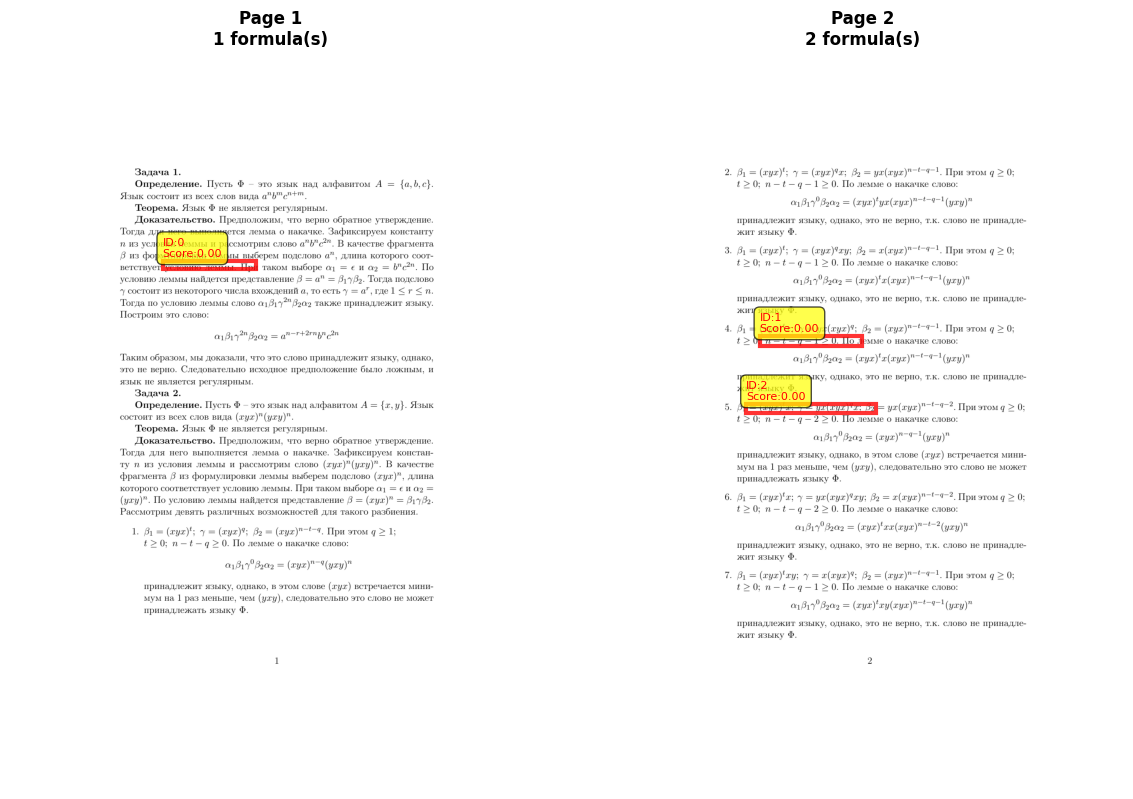

In [31]:
def visualize_search_results(pdf_path: str, search_results: List[SearchResult], max_pages: int = 3):
    """Visualize search results on the original document pages"""
    
    if not os.path.exists(pdf_path):
        print(f"PDF not found: {pdf_path}")
        return
    
    # Group results by page
    results_by_page = defaultdict(list)
    for result in search_results[:max_pages * 3]:  # Limit results
        results_by_page[result.formula.page_num].append(result)
    
    # Open PDF
    doc = fitz.open(pdf_path)
    
    # Process each page with results
    pages_to_show = sorted(results_by_page.keys())[:max_pages]
    
    fig, axes = plt.subplots(1, len(pages_to_show), figsize=(6*len(pages_to_show), 8))
    if len(pages_to_show) == 1:
        axes = [axes]
    
    for idx, page_num in enumerate(pages_to_show):
        # Render page
        page = doc[page_num]
        mat = fitz.Matrix(150/72, 150/72)
        pix = page.get_pixmap(matrix=mat)
        img = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.height, pix.width, pix.n)
        
        if img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
        elif img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Display
        axes[idx].imshow(img)
        
        # Draw bounding boxes for search results
        for result in results_by_page[page_num]:
            x1, y1, x2, y2 = result.formula.bbox
            
            # Scale bbox if needed (assuming same DPI)
            scale = 150 / 200  # from processing DPI to display DPI
            x1, y1, x2, y2 = int(x1*scale), int(y1*scale), int(x2*scale), int(y2*scale)
            
            # Draw rectangle
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                     linewidth=3, edgecolor='red',
                                     facecolor='none', alpha=0.8)
            axes[idx].add_patch(rect)
            
            # Add label
            label = f"ID:{result.formula_id}\nScore:{result.relevance_score:.2f}"
            axes[idx].text(x1, y1-10, label, color='red', fontsize=8,
                          bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))
        
        axes[idx].set_title(f"Page {page_num + 1}\n{len(results_by_page[page_num])} formula(s)", 
                           fontweight='bold')
        axes[idx].axis('off')
    
    doc.close()
    plt.tight_layout()
    plt.show()


# Visualize results from the last search
if 'results' in locals() and results:
    print("Visualizing search results on document pages...")
    visualize_search_results(pdf_path, results, max_pages=2)
else:
    print("No search results to visualize. Run a search first.")

## 11. Save and Load Index

Save the index for later use and demonstrate loading.

In [ ]:
# Save the index
index_path = "lightrag_formula_index.pkl"
rag_index.save(index_path)

# Test loading
print("\n" + "="*60)
print("Testing Index Load")
print("="*60)

new_index = LightRAGIndex()
new_index.load(index_path)

# Verify it works
new_search_engine = LightRAGSearch(new_index)
print("\nTesting search on loaded index...")
test_results = new_search_engine.search_by_formula("x^2", top_k=3)
print(f"Found {len(test_results)} results")

for result in test_results:
    print(f"\n  Formula ID {result.formula_id}: {result.formula.latex[:50]}...")
    print(f"  Score: {result.relevance_score:.3f}")

## 12. Summary and System Architecture

Summary of the LightRAG system architecture and capabilities.

### LightRAG System Architecture

```
┌─────────────────────────────────────────────────────────────────┐
│                    Document Input (PDF/Images)                   │
└────────────────────────────┬────────────────────────────────────┘
                             │
                             ▼
┌─────────────────────────────────────────────────────────────────┐
│              Document Layout Detection (YOLO)                    │
│  ┌──────────┬──────────┬──────────┬──────────┬──────────┐      │
│  │  Text    │ Formula  │  Table   │ Figure   │  Title   │      │
│  └──────────┴──────────┴──────────┴──────────┴──────────┘      │
└────────────────────────────┬────────────────────────────────────┘
                             │
                             ▼
┌─────────────────────────────────────────────────────────────────┐
│                    Content Recognition                           │
│  ┌───────────────────────────┬─────────────────────────────┐   │
│  │  Formula Recognition      │   Text Recognition          │   │
│  │     (pix2tex)             │    (PaddleOCR)              │   │
│  │   Image → LaTeX           │   Image → Text              │   │
│  └───────────────────────────┴─────────────────────────────┘   │
└────────────────────────────┬────────────────────────────────────┘
                             │
                             ▼
┌─────────────────────────────────────────────────────────────────┐
│              Formula Parsing & Graph Construction                │
│        LaTeX → AST → NetworkX DiGraph                           │
└────────────────────────────┬────────────────────────────────────┘
                             │
                             ▼
┌─────────────────────────────────────────────────────────────────┐
│                     LightRAG Index                               │
│  ┌──────────────┬──────────────┬───────────────┬─────────────┐ │
│  │ Symbol Index │ Operator Idx │ Structure Idx │ Context Idx │ │
│  │  x → [1,5]   │ + → [2,4]    │ hash→[1,2,3]  │ word→[ids]  │ │
│  └──────────────┴──────────────┴───────────────┴─────────────┘ │
└────────────────────────────┬────────────────────────────────────┘
                             │
                             ▼
┌─────────────────────────────────────────────────────────────────┐
│                   Multi-Modal Search                             │
│  ┌─────────────────┬─────────────────┬────────────────────┐    │
│  │ Formula Search  │ Context Search  │  Hybrid Search     │    │
│  │ (by structure)  │ (by text)       │  (combined)        │    │
│  └─────────────────┴─────────────────┴────────────────────┘    │
└────────────────────────────┬────────────────────────────────────┘
                             │
                             ▼
┌─────────────────────────────────────────────────────────────────┐
│              Ranked Results with Context                         │
│  Formula + LaTeX + Surrounding Text + Document Location         │
└─────────────────────────────────────────────────────────────────┘
```

### Key Components:

1. **YOLODocLayoutDetector**: Detects document elements (formulas, text, tables, etc.)
2. **FormulaRecognizer**: Converts formula images to LaTeX using pix2tex
3. **TextRecognizer**: OCR for text regions using PaddleOCR
4. **DocumentProcessor**: Orchestrates the pipeline
5. **LaTeXParser & FormulaGraph**: Parse LaTeX into graph structures
6. **LightRAGIndex**: Multi-modal index with:
   - Symbol index (variables, constants)
   - Operator index (functions, operators)
   - Structure index (graph patterns)
   - Context word index (surrounding text)
7. **LightRAGSearch**: Search algorithms:
   - Formula structure search
   - Symbol-based search
   - Context-based search
   - Hybrid multi-modal search

### Search Capabilities:

- **By Formula Structure**: Find formulas with similar mathematical structure
- **By Symbols**: Find formulas containing specific symbols (x, y, α, etc.)
- **By Context**: Find formulas by surrounding text description
- **Hybrid**: Combine multiple search modes with weighted scoring

### Performance Characteristics:

- **Indexing**: O(n × m) where n = formulas, m = formula complexity
- **Symbol/Operator Search**: O(1) lookup + O(k) results
- **Structure Search**: O(h × n) where h = hash lookups
- **Context Search**: O(w × n) where w = query words
- **Storage**: Pickle-based serialization for persistence

### Use Cases:

1. Scientific document search by mathematical content
2. Formula recommendation and similarity finding
3. Context-aware equation retrieval
4. Mathematical knowledge graph construction
5. Educational material indexing
6. Research paper formula discovery